In [1]:
from dataclasses import dataclass

import seaborn as sns
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

from src.components.cdvi import CDVI
from src.components.cdvi_process import CMCD, DIS
from src.components.control import Control
from src.components.encoder import TestEncoder
from src.train.train_static import BetterStaticTargetTrainer
from src.utils.datasets import ContextTestDataset
from src.utils.distros import ContextualGMM
from src.utils.grid import (compute_bd, compute_jsd, create_grid,
                            eval_dist_on_grid, eval_hist_on_grid,
                            eval_kde_on_grid)
from src.utils.visualize import visualize_vals_on_grid_1d

In [2]:
device = torch.device("cpu") 

In [3]:
@dataclass
class Config():
    num_steps = 16
    c_dim = 1
    z_dim = 1
    h_dim = 32
    num_layers = 3
    non_linearity = "SiLU"
    learning_rate = 3e-3
    size = 128
    batch_size = 128

config = Config()

In [4]:
dataset = ContextTestDataset(size=config.size, c_dim=config.c_dim, sampling_factor=0)
dataloader = DataLoader(dataset=dataset, batch_size=config.batch_size, shuffle=True)

In [5]:
encoder = TestEncoder(
    c_dim=config.c_dim, 
    h_dim=config.h_dim
)

control = Control(
    h_dim=config.h_dim, 
    z_dim=config.z_dim, 
    num_layers=config.num_layers, 
    non_linearity=config.non_linearity, 
    num_steps=config.num_steps,
    is_cross_attentive=False,
    num_heads=1
)

dvi_process = DIS(
    device=device, 
    z_dim=config.z_dim, 
    num_steps=config.num_steps, 
    control=control,
    hyper_net=None
)

contextual_target = lambda context, _: ContextualGMM(context, offsets=(5, -5), scales=(1, 1), weights=(0.3, 0.7))

cdvi = CDVI(
    encoder=encoder,
    dvi_process=dvi_process,
    decoder=None,
    contextual_target=contextual_target
).to(device)

In [6]:
optimizer = torch.optim.AdamW(params=cdvi.parameters(), lr=config.learning_rate)

trainer = BetterStaticTargetTrainer(
    device=device,
    cdvi=cdvi,
    train_loader=dataloader,
    val_loader=dataloader,
    optimizer=optimizer,
    scheduler=None,
    wandb_logging=False
)

In [7]:
num_epochs = 1000

losses = trainer.train(
    num_epochs=num_epochs, 
    alpha=None, 
    max_clip_norm=None
)

100%|██████████| 1/1 [00:00<00:00, 21.01it/s, epoch=999, loss=11.1]


(1, 256) (1, 256, 1)


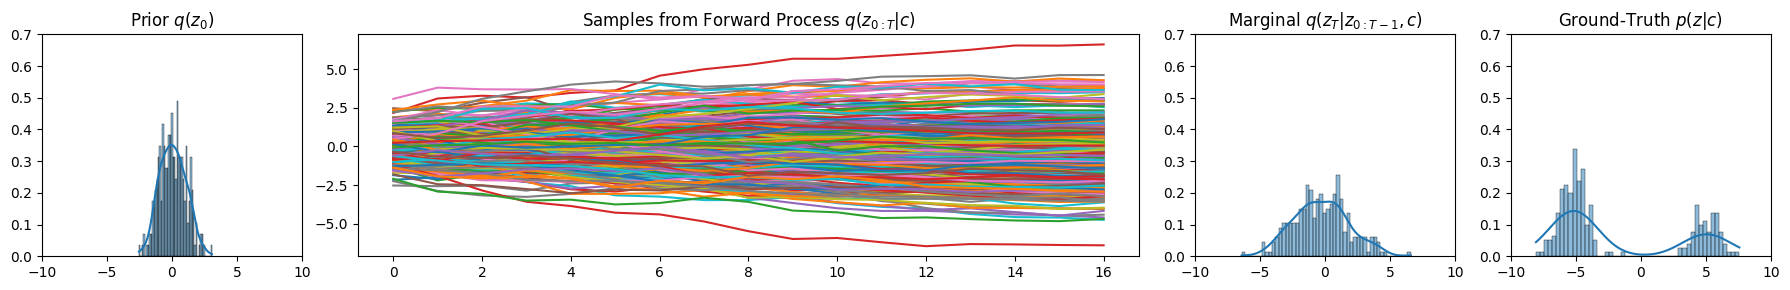

In [ ]:
num_samples = 256

context = dataset.sampling_factor * torch.ones((1, num_samples, 1, config.c_dim), device=device)
p_z_T = cdvi.contextual_target(context, None)

context_embedding = cdvi.encoder(context.to(device), None)[0]
_, _, z_samples = cdvi.dvi_process.run_chain(p_z_T, context_embedding, None)

z_0_samples = z_samples[0].detach().cpu().numpy()
z_T_samples = z_samples[-1].detach().cpu().numpy()
z_trajectories = [[z[0, i, 0].detach().cpu().numpy() for z in z_samples] for i in range(num_samples)]
z_target_samples = p_z_T.sample().detach().cpu().numpy()

z_0_samples = z_0_samples.reshape(-1)
z_T_samples = z_T_samples.reshape(-1)
z_target_samples = z_target_samples.reshape(-1)

fig, ax = plt.subplots(1, 4, figsize=(18, 3), gridspec_kw={'width_ratios': [1, 3, 1, 1]})

sns.histplot(z_0_samples, ax=ax[0], stat="density", bins=50, kde=True)
ax[0].set_title("Prior $q(z_0)$")
ax[0].set_ylabel(None)
ax[0].set_xlim(-10, 10)
ax[0].set_ylim(0, 0.7)

for i in range(num_samples):
    ax[1].plot(z_trajectories[i])
ax[1].set_title("Samples from Forward Process $q(z_{0:T}|c)$")

sns.histplot(z_T_samples, ax=ax[2], stat="density", bins=50, kde=True)
ax[2].set_title("Marginal $q(z_T|z_{0:T-1},c)$")
ax[2].set_ylabel(None)
ax[2].set_xlim(-10, 10)
ax[2].set_ylim(0, 0.7)

sns.histplot(z_target_samples, ax=ax[3], stat="density", bins=50, kde=True)
ax[3].set_title("Ground-Truth $p(z|c)$")
ax[3].set_ylabel(None)
ax[3].set_xlim(-10, 10)
ax[3].set_ylim(0, 0.7)

plt.tight_layout()
plt.show()

jsd: 0.0768237422180581, bd: 0.08983695918081555


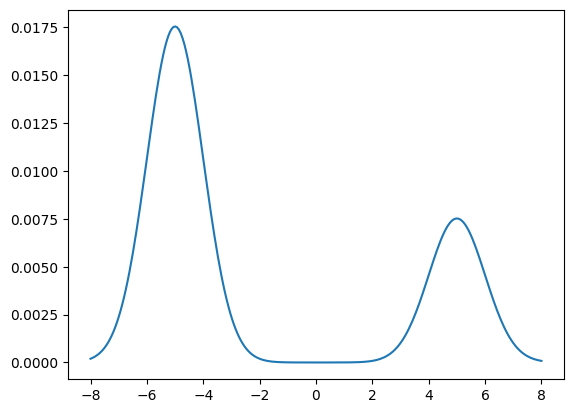

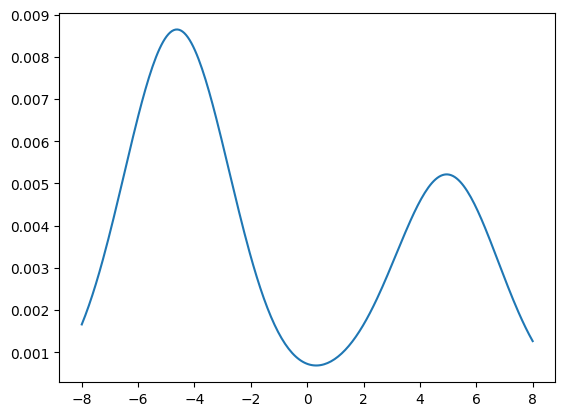

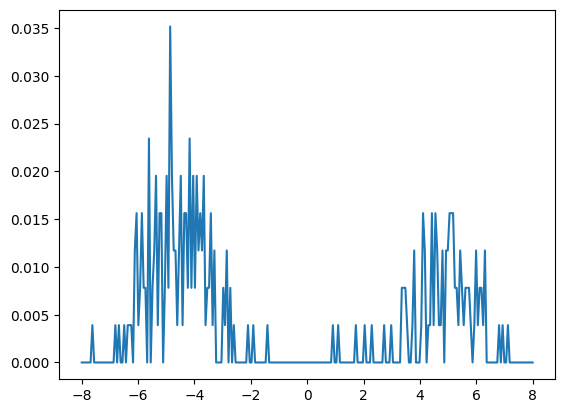

In [11]:
intervals = [(-8, 8)]
num = 256

grid = create_grid(intervals, num)

target_vals = eval_dist_on_grid(grid, p_z_T, device)

dvi_vals = eval_kde_on_grid(grid, z_T_samples)

dvi_vals_2 = eval_hist_on_grid(z_T_samples, intervals, num)

jsd = compute_jsd(target_vals, dvi_vals)
bd = compute_bd(target_vals, dvi_vals)

print(f"jsd: {jsd}, bd: {bd}")

visualize_vals_on_grid_1d(grid, target_vals)
visualize_vals_on_grid_1d(grid, dvi_vals)
visualize_vals_on_grid_1d(grid, dvi_vals_2)